In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import networkx as nx
from networkx import DiGraph

from matplotlib.patches import FancyArrowPatch, Circle
# from GraphDrawer import Graph

In [28]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import networkx as nx
from networkx import DiGraph



class Graph():
    def __init__(self, df, id_col, stage_col, user_col):
        self.df = df
        self.id_col = id_col
        self.user_col = user_col
        self.stage_col = stage_col
        self.stages = self.df[self.stage_col].unique()
        self.act_graph = None
        self.usr_graph = None
        
    def create_activities_graph(self):
        stages = self.df[self.stage_col].unique()
        graph = DiGraph() 
        for stage in stages:
            graph.add_node(stage)
        self.df['from'] = self.df.groupby([self.id_col])[self.stage_col].shift(1)

        edges = self.df.loc[:, ['from', self.stage_col]].drop_duplicates().dropna().values

        graph.add_edges_from(edges)
        self.act_graph = graph
        return graph

    def create_users_graph(self):
        users = self.df[self.user_col].unique()
        graph = DiGraph() 
        for user in users:
            graph.add_node(user)
        self.df['from_user'] = self.df.groupby([self.id_col])[self.user_col].shift(1)

        edges = self.df.loc[:, ['from_user', self.user_col]].drop_duplicates().dropna().values.astype(int)
        graph.add_edges_from(edges)
        self.usr_graph = graph
        return graph
    
    def draw_activities(self, alpha=0.03, labels=None, layout=None, info=None, node_size=700):

        activity_matrix = np.zeros((len(self.stages), len(self.stages)))
        
        for _, row in self.df.iterrows():
            if(pd.isna(row['from'])):
                continue
                
            x_from = int(row['from'])
            x_stag = int(row[self.stage_col])
            activity_matrix[x_from, x_stag] += 1

        self.activity_matrix = activity_matrix
        
        graph = DiGraph()
        
#calculating nodes order
        if layout:
            graph.add_nodes_from(self.act_graph.nodes)
            pos = layout(graph)
        else:
            mat = self.activity_matrix.copy()

            for i in range(mat.shape[0]):
                mat[i,i] = -1
            nodes = []
            nodes.append(np.argmax(mat) // mat.shape[0])
            mat[:, nodes[0]] = -1

            while(True):
                node = np.argmax(mat[nodes[-1],:])
                mat[:,node] = -1
                nodes.append(node)

                if len(nodes) == mat.shape[0]:
                    break 

            graph.add_nodes_from(nodes)
            
            pos = {}
            for i, node in enumerate(nodes[:-2]):
                x = 0.5
                y = 1 - (i + 1) / (len(nodes[:-2]) + 1)
                pos[node] = [x, y]
                
            for i, node in enumerate(nodes[-2:]):
                x = (i + 1) / (2 + 1)
                pos[node] = [x, y]

    
        
# drawing graph

        plt.figure(figsize=(16,16))
        plt.title("Граф перехода активностей")
        
        if(info=='nodes'):
            print("Всего {} видов действий".format(len(self.stages)))
        elif(info=='time'):
            print("Среднее время действия:")
            df = self.df.sort_values('datetime')
            df['datetime_shift'] = df.datetime.shift(1)
            for stage in np.unique(df[self.stage_col]):
                df_ = df.loc[df[self.stage_col]==stage]
                mean = (df_.datetime[1:] - df_.datetime_shift[1:]).mean()
                print(mean, ' - ', labels[stage])
        elif(info=='all'):
            print("Всего {} видов действий\n".format(len(self.stages)))
            print("Среднее время действия:")
            df = self.df.sort_values('datetime')
            df['datetime_shift'] = df.datetime.shift(1)
            for stage in np.unique(df[self.stage_col]):
                df_ = df.loc[df[self.stage_col]==stage]
                mean = (df_.datetime[1:] - df_.datetime_shift[1:]).mean()
                print(mean, ' - ', labels[stage])
            info='edges'
        
        
        for edge in self.act_graph.edges:
            graph.add_edge(edge[0], edge[1], weight=1 + alpha*activity_matrix[int(edge[0]), int(edge[1])])
            
        weights = [graph[u][v]['weight'] for u,v in graph.edges]
        
        
#         else:
#             pos = None
            
#         if not node_size and labels:
#             node_size = max([len(x) for x in labels.values()]) * 250
#         else:
#             node_size = 700 
            
        nx.draw(graph, pos=pos, width=weights, with_labels=True, font_size=10, node_size=node_size, node_shape='D',
                    node_color='c',  edge_color='pink', labels=labels)
        if info=='edges':
            labels = {}
            for edge in self.act_graph.edges:
                labels[edge] = int(activity_matrix[int(edge[0]), int(edge[1])])
            nx.draw_networkx_edge_labels(graph, pos=pos, width=weights, with_labels=True, 
                                        font_size=20, node_size=node_size, 
                                        node_color='b',  edge_color='c', edge_labels=labels)
        plt.show()
        
        return graph, pos, weights
        
        
    def draw_users(self, alpha=0.03, labels=None, layout=None, info=None, node_size=700):

        self.users = np.unique(self.df[self.user_col])
        users_matrix = np.zeros((len(self.users), len(self.users)))

        for _, row in self.df.iterrows():
            if pd.isna(row['from_user']):
                continue
            else:
                user = int(row[self.user_col])
                prev = int(row['from_user'])
                
                users_matrix[prev, user] += 1
                
        self.users_matrix = users_matrix
        
        
        
        graph = nx.DiGraph()

# calculating nodes order
        if layout:
            graph.add_nodes_from(self.usr_graph.nodes)
            pos = layout(graph)
        else:
            mat = self.users_matrix.copy()
            for i in range(mat.shape[0]):
                mat[i,i] = -1

            nodes = []
            nodes.append(np.argmax(mat) // mat.shape[0])
            mat[:, nodes[0]] = -1

            while(True):
                node = np.argmax(mat[nodes[-1],:])
                mat[:,node] = -1
                nodes.append(node)

                if len(nodes) == mat.shape[0]:
                    break 

            graph.add_nodes_from(nodes)
            
            pos = {}
            for i, node in enumerate(nodes[:-2]):
                x = 0.5
                y = 1 - (i + 1) / (len(nodes[:-2]) + 1)
                pos[node] = [x, y]
                
            for i, node in enumerate(nodes[-2:]):
                x = (i + 1) / (2 + 1)
                pos[node] = [x, y]
            
            
        
        for edge in self.usr_graph.edges:
            if self.users_matrix[int(edge[0]), int(edge[1])] > 0:
                graph.add_edge(edge[0], edge[1], weight = 1 + alpha*self.users_matrix[edge[0], edge[1]])
                
              
# drawing graph

        if(info=='nodes'):
            print("Всего {} пользователей".format(len(self.users)))
        elif(info=='time'):
            print("Среднее время пользователя:")
            df = self.df.sort_values('datetime')
            df['datetime_shift'] = df.datetime.shift(1)
            for user in np.unique(df[self.user_col]):
                df_ = df.loc[df[self.user_col]==user]
                mean = (df_.datetime[1:] - df_.datetime_shift[1:]).mean()
                print(mean, ' - ', labels[user])
                
        elif(info=='all'):
            print("Всего {} пользователей\n".format(len(self.users)))
            print("Среднее время пользователя:")
            df = self.df.sort_values('datetime')
            df['datetime_shift'] = df.datetime.shift(1)
            for user in np.unique(df[self.user_col]):
                df_ = df.loc[df[self.user_col]==user]
                mean = (df_.datetime[1:] - df_.datetime_shift[1:]).mean()
                print(mean, ' - ', labels[user])
            info='edges'
            

            
            
#         if not node_size and labels:
#             node_size = max([len(x) for x in labels.values()]) * 250
#         else:
#             node_size = 500
            
        
        
        plt.figure(figsize=(16,16))
        plt.title("Граф социальных связей")
        
        weights = [graph[u][v]['weight'] for u,v in graph.edges]
#         print(weights)
        nx.draw(graph, pos=pos, width=weights, with_labels=True, font_size=12, node_size=node_size, node_shape="D",
                node_color='pink', edge_color='c', labels=labels)
        if info=='edges':
            lab = {}
            for edge in self.usr_graph.edges:
                if edge[0] == edge[1]:
                    continue
                lab[edge] = str(int(self.users_matrix[int(edge[0]), int(edge[1])])) + '<->' \
                + str(int(self.users_matrix[int(edge[1]), int(edge[0])]))
                
            nx.draw_networkx_edge_labels(graph, pos=pos, width=weights, with_labels=True, 
                                        font_size=12, node_size=500,
                                        node_color='b',  edge_color='c', edge_labels=lab)
        plt.show()   
        return graph, pos, weights

### Generating Data


In [3]:
from ProcessGenerator import FeatureGenerator, SimpleProcessMaker

In [4]:
stages = np.array(['A', 'B', 'C', 'D', 'E', 'F'])
probas=np.array([0.1, 0.8, 0.7, 0.5, 0.5, 0.03])
maker = SimpleProcessMaker(stages=stages, probas=probas)

In [5]:
gen_df = pd.DataFrame()
for idx in range(100):
    d = maker.make_process_sample(idx)
    gen_df = gen_df.append(d)
    
gen_df

,id,stages,dt
0,0,A,2020-01-01
1,0,D,2020-01-09
2,0,F,2020-01-13
0,1,A,2020-01-01
1,1,F,2020-01-05
...,...,...,...
0,98,F,2020-01-01
1,98,A,2020-01-05
0,99,A,2020-01-01
1,99,D,2020-01-08


In [6]:
gen = FeatureGenerator()

In [7]:
num_users = 5
gen_df['user'] = ['user_' + gen.label_features(label_type='string', nb_unique_labels=num_users)[0][-1] for _ in range(len(gen_df))]
gen_df.head()

,id,stages,dt,user
0,0,A,2020-01-01,user_0
1,0,D,2020-01-09,user_2
2,0,F,2020-01-13,user_4
0,1,A,2020-01-01,user_4
1,1,F,2020-01-05,user_2


In [8]:
gen_df["user_id"] = gen_df['user']
gen_df['stage_id'] = gen_df['stages']

act_id = dict()
id_act = dict()
usr_id = dict()
id_usr = dict()

for i, act in enumerate(np.unique(gen_df.stages)):
    act_id[act] = i
    id_act[i] = act

for i, usr in enumerate(np.unique(gen_df.user)):
    usr_id[usr] = i
    id_usr[i] = usr

    
user_id = [usr_id[x] for x in gen_df['user'].values]
stage_id = [act_id[x] for x in gen_df['stages'].values]

gen_df.user_id = user_id
gen_df.stage_id = stage_id

### Creating graphs

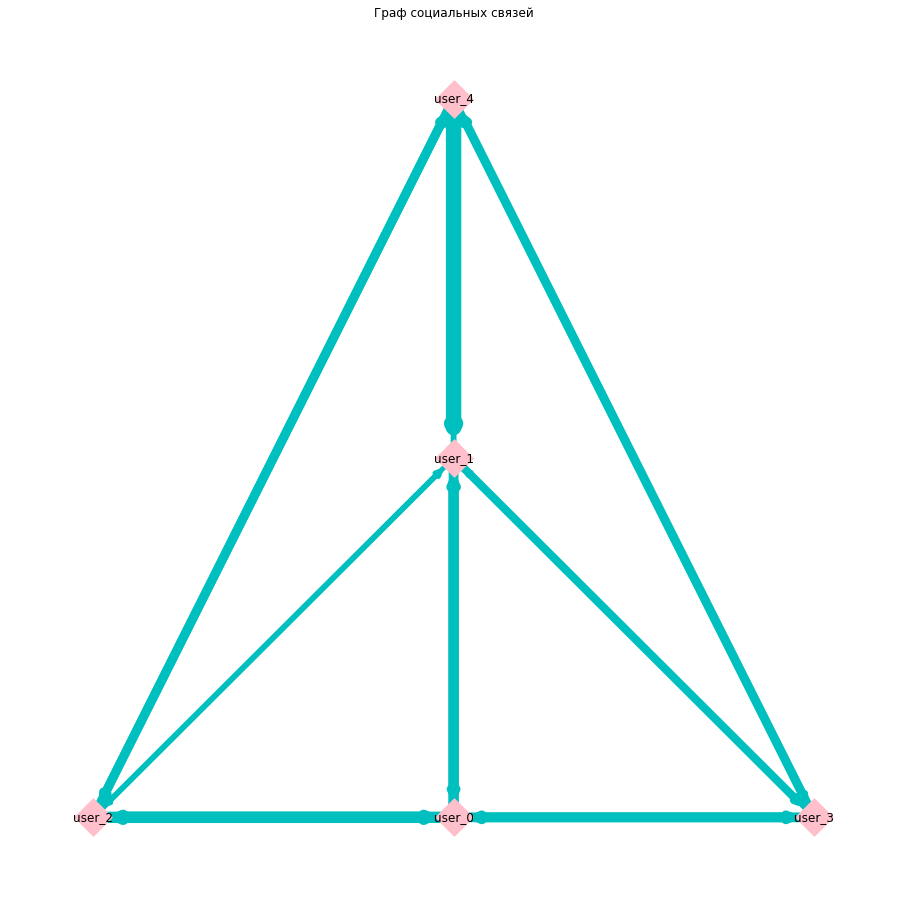

(<networkx.classes.digraph.DiGraph at 0x1a2531c2d0>,
 {4: [0.5, 0.75],
  1: [0.5, 0.5],
  0: [0.5, 0.25],
  2: [0.3333333333333333, 0.25],
  3: [0.6666666666666666, 0.25]},
 [9.0,
  6.6000000000000005,
  15.4,
  7.4,
  4.2,
  8.2,
  5.800000000000001,
  10.600000000000001,
  9.8,
  5.0,
  11.4,
  4.2,
  10.600000000000001,
  9.8,
  4.2,
  9.0,
  11.4,
  5.800000000000001,
  6.6000000000000005,
  9.8,
  7.4,
  4.2,
  9.0,
  9.8,
  5.0])

In [9]:
graph = Graph(gen_df, 'id', 'stages', 'user_id')
graph.create_users_graph()
graph.draw_users(alpha=0.8, labels=id_usr)

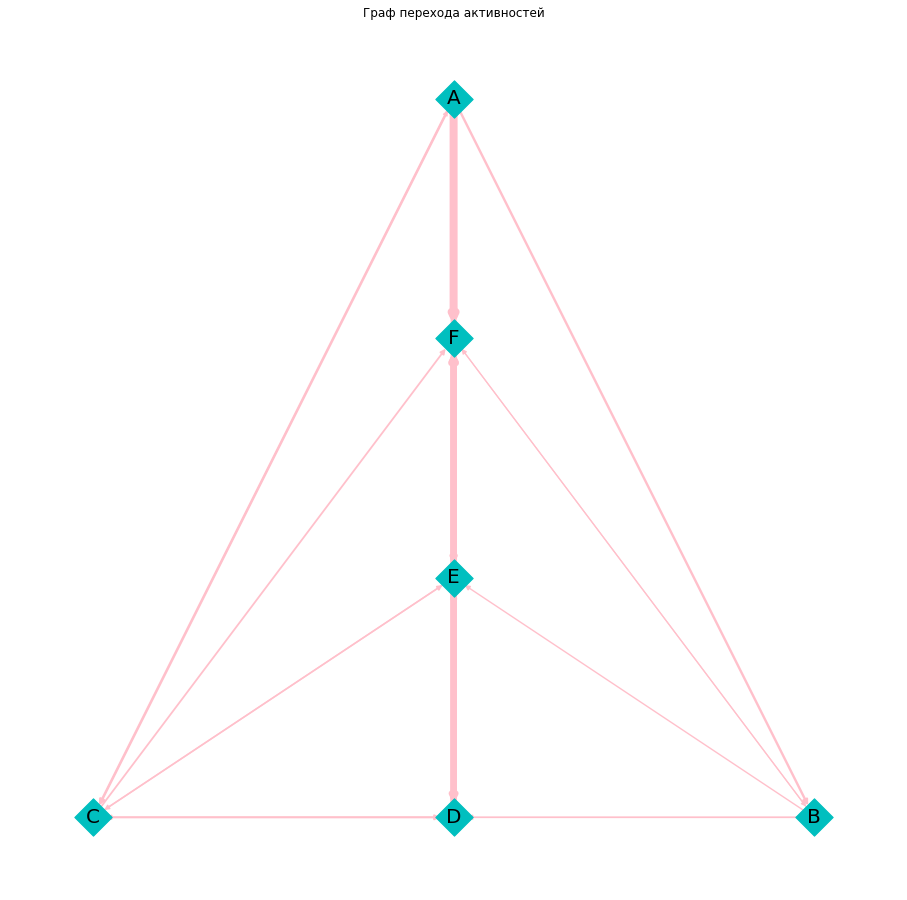

In [10]:
graph = Graph(gen_df, 'id', 'stage_id', 'user_id')
graph.create_activities_graph()
g, pos, w = graph.draw_activities(alpha=0.2, labels=id_act)

In [11]:
graph.activity_matrix

array([[ 0.,  7.,  8., 25., 17., 35.],
       [ 0.,  0.,  1.,  3.,  2.,  1.],
       [ 1.,  0.,  0.,  5.,  3.,  4.],
       [ 9.,  0.,  1.,  0., 12., 29.],
       [ 2.,  0.,  2.,  8.,  0., 25.],
       [ 6.,  1.,  0.,  4.,  8.,  0.]])

In [12]:
g.nodes

NodeView((0, 5, 4, 3, 2, 1))

### Drawing fancy arrows

In [13]:
from matplotlib.patches import Ellipse

In [32]:
def draw_network(G,pos,ax,sg=None, labels=None):

    for n in G:
        c=Ellipse(xy=pos[n],width=0.1, height=0.05, color='pink')
        ax.add_patch(c)
        if labels:
            text = labels[n]
        else:
            text = '^_^'
#         ax.text(pos[n][0], pos[n][1], text, bbox={'facecolor': 'red', 'alpha': 1, 'pad': 10})

        ax.text(pos[n][0]-len(text)*0.00275, pos[n][1], text, fontsize=10)
        G.nodes[n]['patch']=c
        x,y=pos[n]
    for (u,v) in G.edges:
        n1=G.nodes[u]['patch']
        n2=G.nodes[v]['patch']
        rad=0.3
        color='k'
        
        lw = G[u][v]['weight']

        e = FancyArrowPatch(n1.center,n2.center,patchA=n1,patchB=n2,
                            arrowstyle='-|>',
                            connectionstyle='arc3,rad=%s'%rad,
                            mutation_scale=15,
                            lw=lw,
                            alpha=0.5,
                            color=color)

        ax.add_patch(e)
    return e

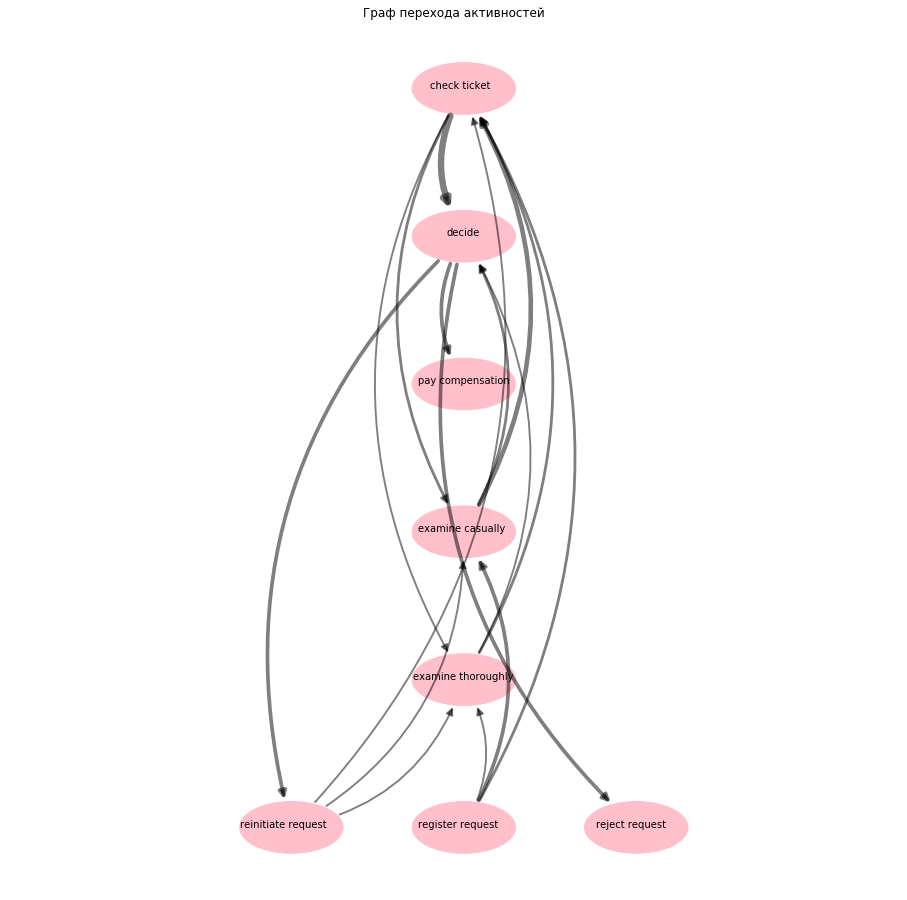

In [33]:
plt.figure(figsize=(16,16))
ax=plt.gca()

plt.title("Граф перехода активностей")
draw_network(g,pos,ax, labels=id_act)
# ax.autoscale()
plt.axis('equal')
plt.axis('off')

plt.show()

### Using existing log

In [16]:
log = pd.read_csv("pm_data/Chapter_1/running-example.csv", sep=';')
log['datetime'] = pd.to_datetime(log["dd-MM-yyyy:HH.mm"], format='%d-%m-%Y:%H.%M')
log.drop("dd-MM-yyyy:HH.mm", axis=1, inplace=True)
log.head(10)

,Case ID,Event ID,Activity,Resource,Costs,datetime
0,1,35654423,register request,Pete,50,2010-12-30 11:02:00
1,1,35654424,examine thoroughly,Sue,400,2010-12-31 10:06:00
2,1,35654425,check ticket,Mike,100,2011-01-05 15:12:00
3,1,35654426,decide,Sara,200,2011-01-06 11:18:00
4,1,35654427,reject request,Pete,200,2011-01-07 14:24:00
5,2,35654483,register request,Mike,50,2010-12-30 11:32:00
6,2,35654485,check ticket,Mike,100,2010-12-30 12:12:00
7,2,35654487,examine casually,Sean,400,2010-12-30 14:16:00
8,2,35654488,decide,Sara,200,2011-01-05 11:22:00
9,2,35654489,pay compensation,Ellen,200,2011-01-08 12:05:00


In [17]:
log["User ID"] = log['Resource']
log['Activity ID'] = log['Activity']

act_id = dict()
id_act = dict()
usr_id = dict()
id_usr = dict()

for i, act in enumerate(np.unique(log.Activity)):
    act_id[act] = i
    id_act[i] = act

for i, usr in enumerate(np.unique(log.Resource)):
    usr_id[usr] = i
    id_usr[i] = usr

for i in range(log.shape[0]):
    log.loc[i,'User ID'] = usr_id[log.loc[i,'Resource']]
    log.loc[i,'Activity ID'] = act_id[log.loc[i,'Activity']]

In [18]:
log.head()

,Case ID,Event ID,Activity,Resource,Costs,datetime,User ID,Activity ID
0,1,35654423,register request,Pete,50,2010-12-30 11:02:00,2,5
1,1,35654424,examine thoroughly,Sue,400,2010-12-31 10:06:00,5,3
2,1,35654425,check ticket,Mike,100,2011-01-05 15:12:00,1,0
3,1,35654426,decide,Sara,200,2011-01-06 11:18:00,3,1
4,1,35654427,reject request,Pete,200,2011-01-07 14:24:00,2,7


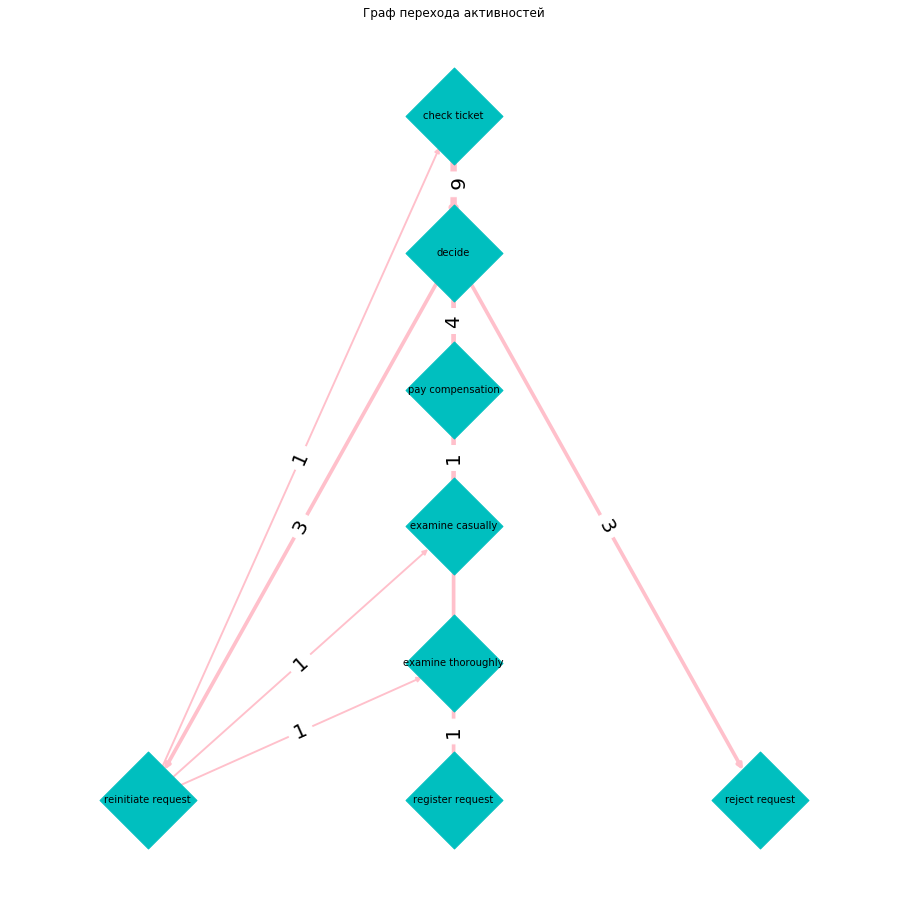

In [31]:
graph = Graph(log, 'Case ID', 'Activity ID', 'User ID')
graph.create_activities_graph()
g, pos, w = graph.draw_activities(alpha=0.9, labels=id_act,  info='edges', node_size = 4700)

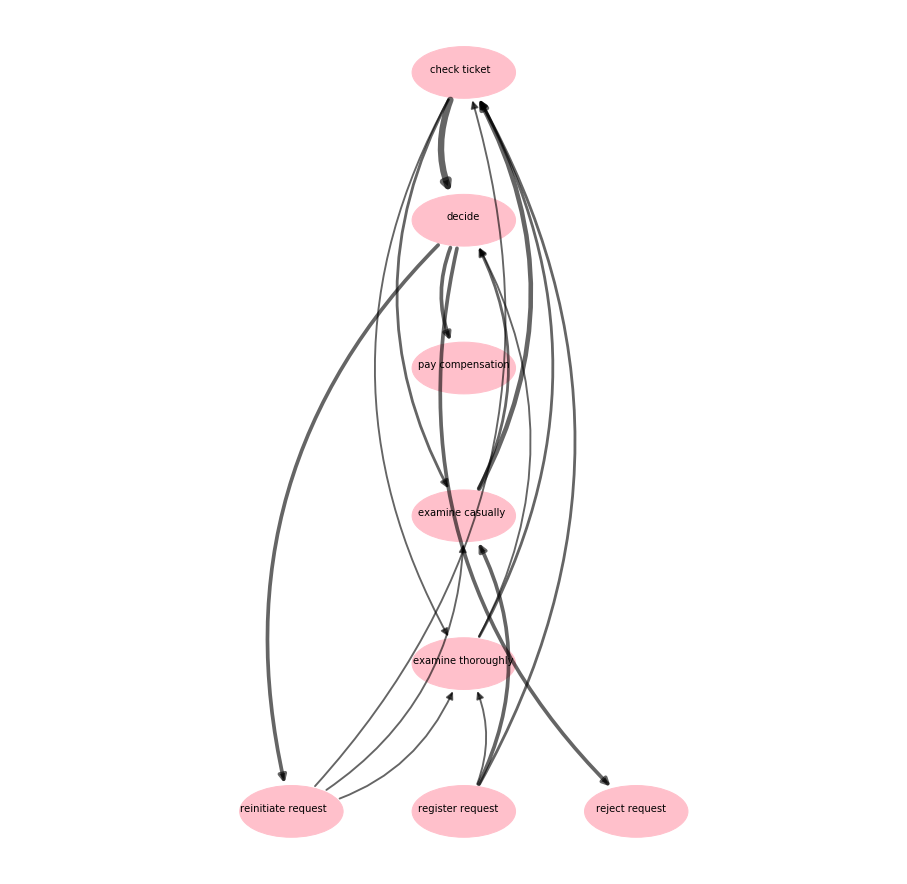

In [20]:
plt.figure(figsize=(16,16))
ax=plt.gca()

draw_network(g,pos,ax,labels=id_act)

plt.axis('equal')
plt.axis('off')

plt.show()

Среднее время действия:
0 days 09:39:15  -  check ticket
0 days 20:49:37.500000  -  decide
0 days 08:49:48  -  examine casually
0 days 01:43:00  -  examine thoroughly
0 days 22:37:00  -  pay compensation
0 days 04:06:24  -  register request
1 days 02:10:00  -  reinitiate request
1 days 00:35:00  -  reject request


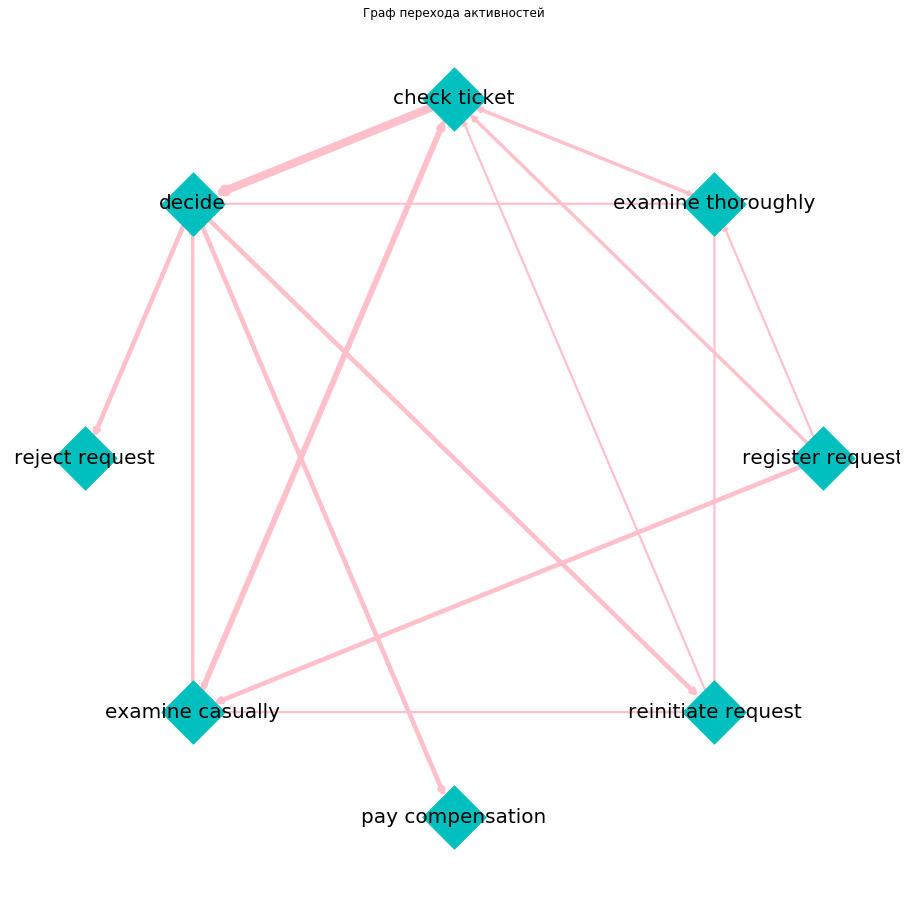

(<networkx.classes.digraph.DiGraph at 0x1a26c4a650>,
 {5: array([1.00000000e+00, 1.83784272e-08]),
  3: array([0.70710678, 0.70710677]),
  0: array([-1.73863326e-08,  9.99999992e-01]),
  1: array([-0.70710672,  0.70710677]),
  7: array([-9.99999947e-01, -6.90443471e-08]),
  2: array([-0.70710678, -0.70710667]),
  4: array([ 3.82499349e-08, -9.99999955e-01]),
  6: array([ 0.70710666, -0.70710685])},
 [2.2,
  3.4,
  4.6,
  3.4,
  2.2,
  8.2,
  3.4,
  2.2,
  4.6,
  4.6,
  4.6,
  3.4,
  5.8,
  2.2,
  2.2,
  2.2])

In [21]:
graph.draw_activities(alpha=1.2, labels=id_act, layout=nx.circular_layout, info='time', node_size=2000)

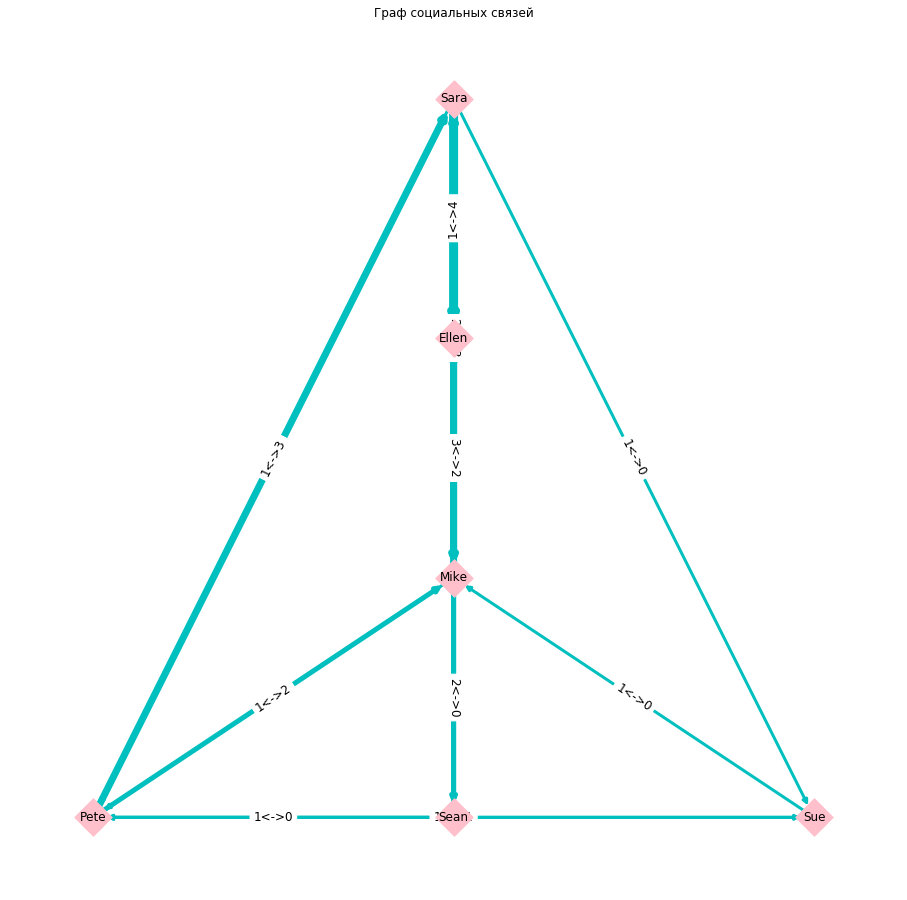

In [23]:
graph = Graph(log, 'Case ID', 'Activity ID', 'User ID')
g = graph.create_users_graph()
g, pos, w = graph.draw_users(alpha=2, labels=id_usr,  info='edges')

Среднее время пользователя:
0 days 18:17:10  -  Ellen
0 days 08:22:42  -  Mike
0 days 03:58:50  -  Pete
0 days 19:59:43.636363  -  Sara
0 days 01:43:00  -  Sean
0 days 20:18:00  -  Sue


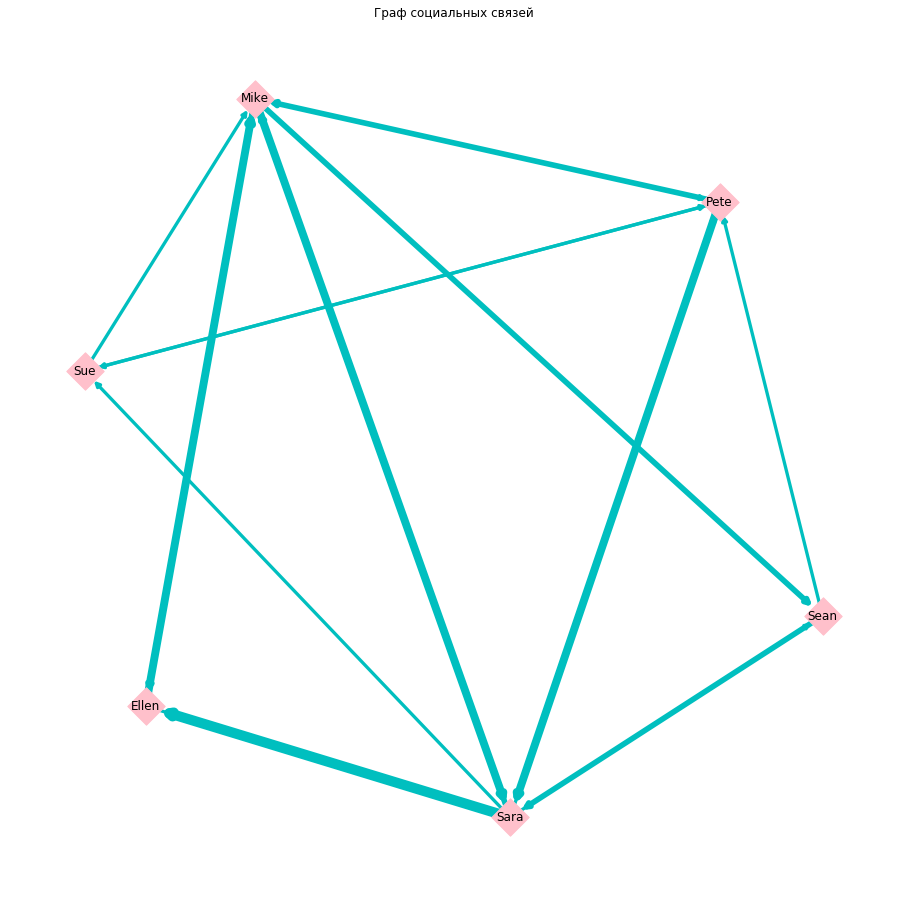

(<networkx.classes.digraph.DiGraph at 0x1a273b5f90>,
 {2: array([0.72486754, 0.71994524]),
  5: array([-0.82642993,  0.26330543]),
  1: array([-0.41094438,  1.        ]),
  3: array([ 0.21319477, -0.94277662]),
  4: array([ 0.97642838, -0.39827079]),
  0: array([-0.67711638, -0.64220325])},
 [3.3,
  5.6,
  7.8999999999999995,
  3.3,
  3.3,
  7.8999999999999995,
  3.3,
  5.6,
  5.6,
  3.3,
  3.3,
  10.2,
  7.8999999999999995,
  3.3,
  3.3,
  5.6,
  5.6,
  3.3,
  3.3,
  7.8999999999999995])

In [25]:
graph.draw_users(alpha=2.3, labels=id_usr, layout=nx.spring_layout, info='time')

In [ ]:
plt.figure(figsize=(16,16))
ax=plt.gca()

draw_network(g,pos,ax)

plt.axis('equal')
plt.axis('off')

plt.show()

In [ ]:
# def draw_network(G,pos,ax,sg=None, weights=None):

#     for n in G:
#         c=Ellipse(xy=pos[n],width=0.1, height=0.05)
#         ax.add_patch(c)
#         G.nodes[n]['patch']=c
#         x,y=pos[n]
# #     seen={}
#     for (u,v,d) in G.edges(data=True):
#         n1=G.nodes[u]['patch']
#         n2=G.nodes[v]['patch']
#         rad=0.3
# #         if (u,v) in seen:
# #             rad=seen.get((u,v))
# #             rad=(rad+np.sign(rad)*0.1)*-1
#         alpha=0.9
#         color='k'
        
#         if weights:
#             lw = weights[u,v]

#         e = FancyArrowPatch(n1.center,n2.center,patchA=n1,patchB=n2,
#                             arrowstyle='-|>',
#                             connectionstyle='arc3,rad=%s'%rad,
#                             mutation_scale=15,
#                             lw=4,
#                             alpha=alpha,
#                             color=color)
# #         seen[(u,v)]=rad
#         ax.add_patch(e)
#     return e